In [1]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
project_dir='/data/projects/rf1-mbme-pilot'
subs=pd.read_csv('../derivatives/exclusions.csv')
print("We collected and downloaded data from %s subjects"%(len(subs['sub'].unique())))
GoodSubs=subs.groupby(by='sub').sum()
#print(GoodSubs.columns)
GoodSubs=GoodSubs[
    (GoodSubs['FD_exclusion']<=2)&(
        GoodSubs['ABS_exclusion']<=1)&(
        GoodSubs['Beh_TrialExclusion']<=2)].reset_index()
subs=subs[subs['sub'].isin(GoodSubs['sub'].values)].sort_values(by='sub')
subs.reset_index(inplace=True)

HC=[]
for index, row in subs.iterrows():
    if row['acq'] in ['mb1me4','mb3me4','mb6me4']:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_echo-1_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    else:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    #print(fname)
    f = open(fname)
    data = json.load(f)
    HC.append(data['ReceiveCoilName'])
    f.close()
subs['HeadCoil']=HC
subs['MB'] =  [int(re.search('mb(.*)me',str(x)).group(1)) for x in subs['acq']]
subs['ME'] =  [int(re.search('me(.*)',str(x)).group(1)) for x in subs['acq']]

print(" There are %s number of subjects who passed the exclusion criteria."%(len(subs['sub'].unique())))
print(" %s Were collected using a 64 channel headcoil and %s with a 20 channel headcoil"%(len(subs[subs['HeadCoil']=='HeadNeck_64']['sub'].unique()),
                                                                                          len(subs[subs['HeadCoil']=='HeadNeck_20']['sub'].unique())))
  

We collected and downloaded data from 43 subjects
 There are 32 number of subjects who passed the exclusion criteria.
 19 Were collected using a 64 channel headcoil and 13 with a 20 channel headcoil


# Count Subjects with full L1 output

In [3]:
act=[]
ppi=[]
L2ppi=[]
for index,row in subs.iterrows():
    sub=row['sub']
    acq=row['acq']
    act.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    L2ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L2_task-sharedreward_model-1_type-ppi_seed-VS_thr5_sm-4.gfeat/cope10.feat/stats/cope1.nii.gz'%(sub)))

subs['L1act']=act
subs['L1ppi']=ppi
subs['L2ppi']=L2ppi
#display(subs)
subs[subs['L2ppi']==False].head()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi
102,249,sub-10185,mb6me1,2,0.777281,0.109853,False,False,False,HeadNeck_20,6,1,True,True,False
103,248,sub-10185,mb1me4,0,0.445697,0.061965,False,False,False,HeadNeck_20,1,4,True,True,False
104,247,sub-10185,mb6me4,2,0.474361,0.077345,False,False,False,HeadNeck_20,6,4,False,False,False
105,246,sub-10185,mb3me1,0,1.528850,0.128609,False,True,False,HeadNeck_20,3,1,True,True,False
106,245,sub-10185,mb3me4,1,0.624076,0.079947,False,False,False,HeadNeck_20,3,4,True,True,False


VS


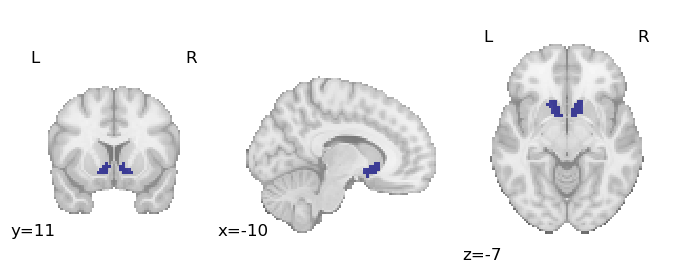

RVS


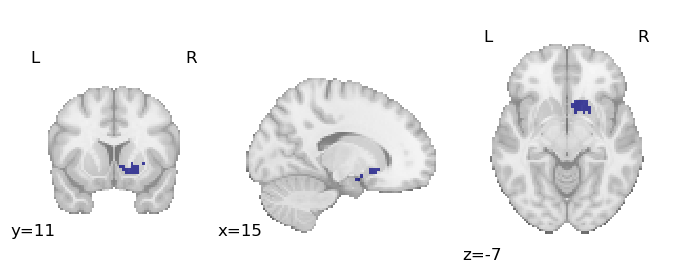

LVS


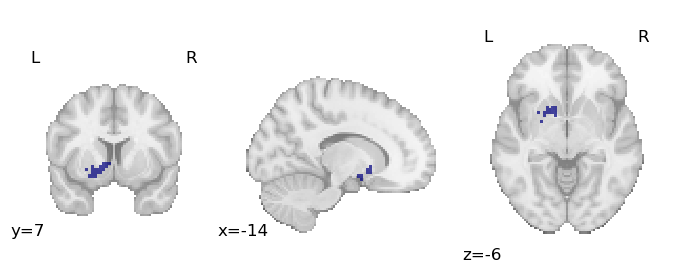

vmPFC


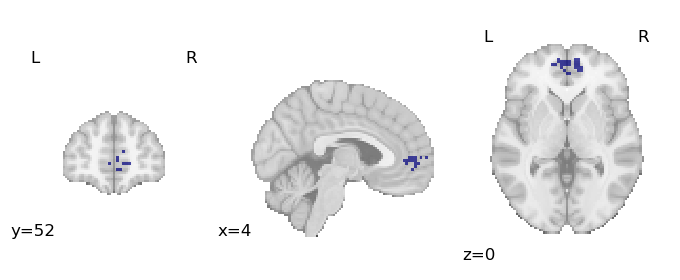

FFA


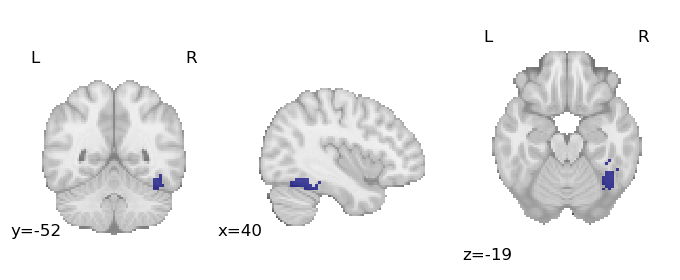

sCerb


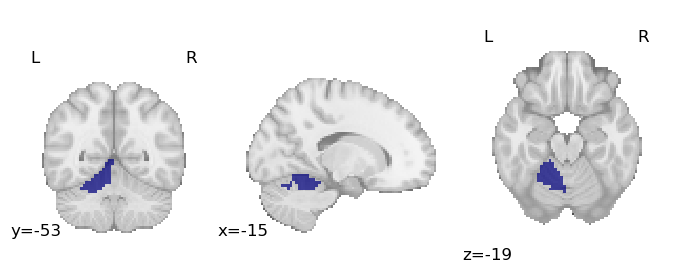

iCerb


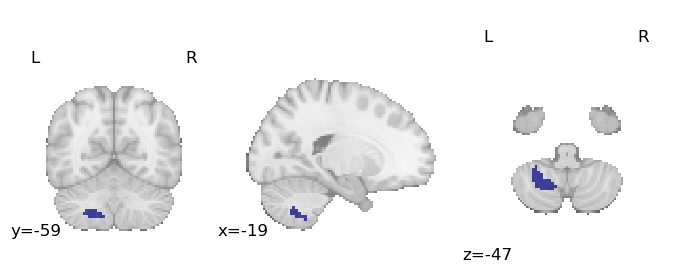

Motor


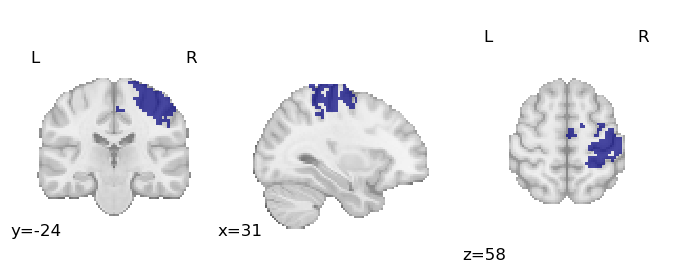

In [4]:
from nilearn import  image
#Striatum Mask
if 1==1:
    VS_mask='../masks/ROI-VS_cname-prereg.nii.gz'
    rstr_mask='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
    lstr_mask='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
    pfc_mask='../masks/fROI-vmPFC_cname-RewVsPun_zstat-1.nii.gz'
    FFA_mask='../masks/fROI-FFA_cname-StrVsComp_zstat-1.nii.gz'
    sCerb_mask='../masks/fROI-sCerb_cname-LeftVsRight_zstat-1.nii.gz'
    iCerb_mask='../masks/fROI-iCerb_cname-LeftVsRight_zstat-1.nii.gz'
    motor_mask='../masks/fROI-Motor_cname-LeftVsRight_zstat-1.nii.gz'
    mask_list=[VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]
    
    for mask in mask_list:
        str_mask=NiftiMasker(mask_img=mask)
        mask_name=re.search('ROI-(.*)_cname',mask).group(1)
        print(mask_name)
        plotting.plot_roi(mask,draw_cross=False)
        plt.savefig("../derivatives/figures/mask_%s.svg"%(mask_name))
        plt.show()

# VS-vmPFC Reward Activiation

In [6]:
masker= NiftiMasker(mask_img=pfc_mask)
                   
copes=[]
zstats=[]
varcopes=[]

for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope13.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat13.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope13.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        #x=masker.fit_transform(varcope)
        #varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        #varcopes.append(np.nan)
        
subs = subs.assign(vmPFC_RP_cope=copes,vmPFC_RP_zstats=zstats)
               #VS_Reward_varcope=varcopes)
                   
copes=[]
zstats=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope15.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat15.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope15.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        #x=masker.fit_transform(varcope)
        #varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        #varcopes.append(np.nan)
        
subs = subs.assign(vmPFC_RN_cope=copes,
               vmPFC_RN_zstats=zstats)
               #VS_Reward_varcope=varcopes)

                   
copes=[]
zstats=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope16.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat16.nii.gz'%(sub,aqc)
    #varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope16.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        #x=masker.fit_transform(varcope)
        #varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        #varcopes.append(np.nan)
        
subs = subs.assign(vmPFC_NP_cope=copes,
               vmPFC_NP_zstats=zstats)
               #VS_Reward_varcope=varcopes)
copes=[]
zstats=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope17.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat17.nii.gz'%(sub,aqc)
    #varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope16.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        #x=masker.fit_transform(varcope)
        #varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        #varcopes.append(np.nan)
        
subs = subs.assign(vmPFC_conn_cope=copes,
               vmPFC_conn_zstats=zstats)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [01:40<00:00,  1.90it/s]


# VS-vmpfc Rew>Pun Connectivity

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: vmPFC_RP_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.2129         
Min. group size:  6       Log-Likelihood:     -85.2989       
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.286     0.162  -1.763  0.078  -0.603   0.032
MB              0.071     0.041   1.725  0.085  -0.010   0.151
ME              0.079     0.055   1.437  0.151  -0.029   0.187
MB:ME          -0.019     0.014  -1.345  0.179  -0.046   0.009
Group Var       0.012     0.037                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: vmPFC_RP_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              17.1928      
Min. group size:  6       Log-Likelihood:     -329.5915    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    -2.047     1.480  -1.383  0.167  -4.948   0.854
MB            0.507     0.367   1.380  0.168  -0.213   1.227
ME            0.244     0.493   0.495  0.620  -0.723   1.211
MB:ME        -0.072     0.126  -0.572  0.568  -0.319   0.175
Group Var     2.320     0.456                               
===========================================================

"""

HeadNeck_20
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: vmPFC_RP_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.1736         
Min. group size:  5       Log-Likelihood:     -46.0442       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.023     0.188   0.121  0.904  -0.345   0.391
MB              0.010     0.047   0.220  0.826  -0.082   0.103
ME             -0.042     0.064  -0.659  0.510  -0.167   0.083
MB:ME           0.005     0.016   0.311  0.755  -0.027   0.037
Group Var       0.000     0.085                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: vmPFC_RP_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              31.7835      
Min. group size:  5       Log-Likelihood:     -215.4959    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     1.206     2.542   0.474  0.635  -3.776   6.188
MB           -0.156     0.641  -0.243  0.808  -1.412   1.100
ME           -1.267     0.863  -1.468  0.142  -2.957   0.424
MB:ME         0.224     0.220   1.018  0.309  -0.208   0.656
Group Var     0.133     0.475                               
===========================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    vmPFC_RP_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.2034         
Min. group size:       5          Log-Likelihood:        -132.3034      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.023    0.204  0.114 0.909 -0.376  0.422
HeadCoil[T.HeadNeck_64]       -0.309    0.257 -1.202 0.229 -0.812  0.195
MB                             0.010    0.051  0.202 0.840 -0.090  0.111
MB:HeadCoil[T.HeadNeck_64]     0.060    0.065  0.926 0.354 -0.067  0.188
ME                            -0.042    0.069 -0.609 0.543 -0.177  0.093
ME:HeadCoil[T.HeadNeck_64]     0.121    0.087  1.383 0.167 -0.050  0.292
MB:ME                          0.005    0.018  0.288 0.774 -0.029  0.040
MB:ME:HeadCoil[T.HeadNeck_64] -0.024    0.022 -1.072 0.284 -0.068  0.020
Group Var                      0.002    0.023                           
========================================================================

"""

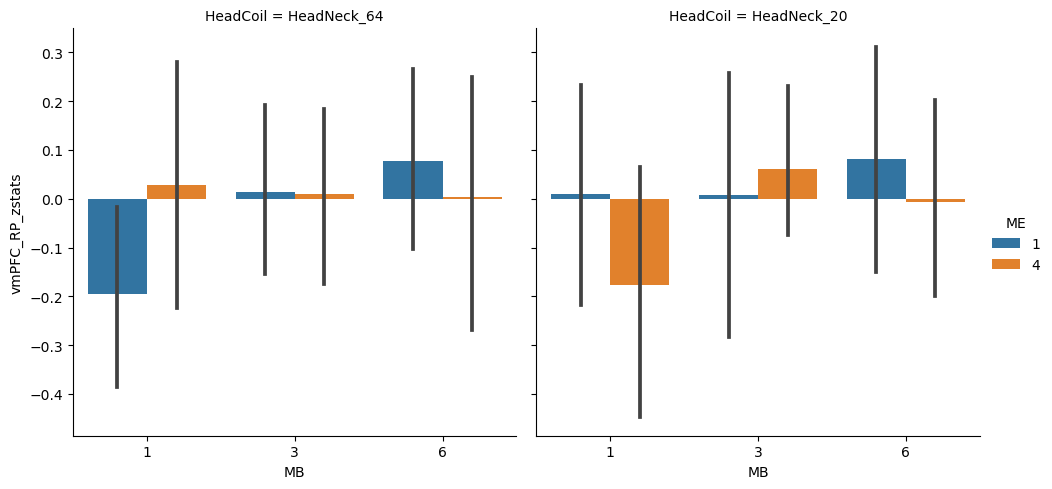

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM     Dependent Variable:     vmPFC_RP_cope
No. Observations:      183         Method:                 REML         
No. Groups:            31          Scale:                  22.5827      
Min. group size:       5           Log-Likelihood:         -548.4269    
Max. group size:       6           Converged:              Yes          
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      1.259    2.173  0.579 0.562 -2.999  5.517
HeadCoil[T.HeadNeck_64]       -3.306    2.742 -1.205 0.228 -8.680  2.069
MB                            -0.167    0.541 -0.308 0.758 -1.226  0.893
MB:HeadCoil[T.HeadNeck_64]     0.674    0.685  0.983 0.325 -0.669  2.017
ME                            -1.270    0.728 -1.744 0.081 -2.696  0.157
ME:HeadCoil[T.HeadNeck_64]     1.514    0.922  1.643 0.100 -0.293  3.320
MB:ME                          0.225    0.186  1.211 0.226 -0.139  0.590
MB:ME:HeadCoil[T.HeadNeck_64] -0.297    0.235 -1.263 0.207 -0.759  0.164
Group Var                      1.546    0.326                           
========================================================================

"""

<Figure size 640x480 with 0 Axes>

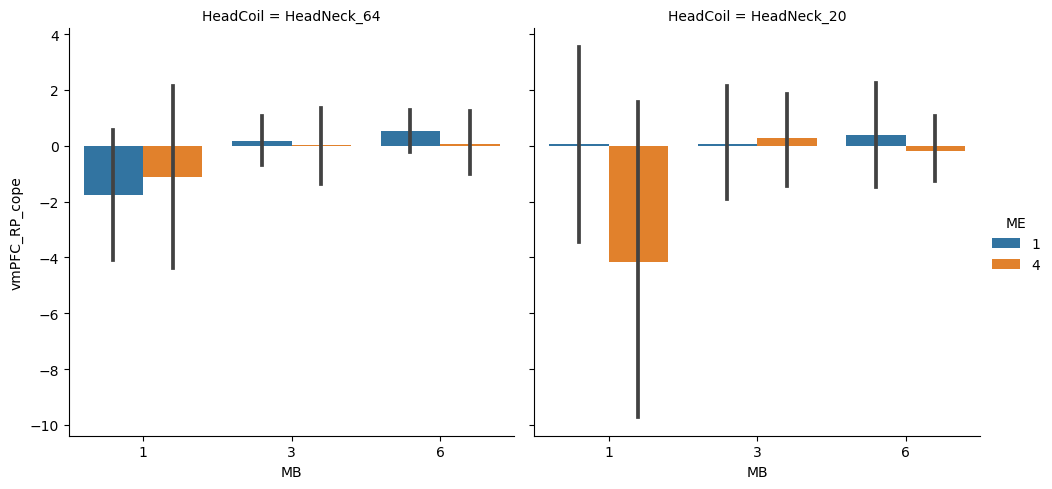

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('vmPFC_RP_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('vmPFC_RP_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('vmPFC_RP_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='vmPFC_RP_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/Reward_VS-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('vmPFC_RP_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='vmPFC_RP_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Reward_VS-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('VS_Reward_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='VS_Reward_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Reward_VS-act_varcope.svg")


# VS-vmpfc Rew>Neu Connectivity

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: vmPFC_RN_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.1836         
Min. group size:  6       Log-Likelihood:     -74.5850       
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.392     0.149  -2.634  0.008  -0.683  -0.100
MB              0.082     0.038   2.165  0.030   0.008   0.157
ME              0.037     0.051   0.729  0.466  -0.063   0.137
MB:ME          -0.000     0.013  -0.035  0.972  -0.026   0.025
Group Var       0.000     0.026                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: vmPFC_RN_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              21.5806      
Min. group size:  6       Log-Likelihood:     -339.1560    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    -4.391     1.629  -2.695  0.007  -7.585  -1.198
MB            0.910     0.412   2.211  0.027   0.103   1.716
ME            0.321     0.553   0.581  0.561  -0.762   1.405
MB:ME        -0.030     0.141  -0.210  0.834  -0.306   0.247
Group Var     1.099     0.368                               
===========================================================

"""

HeadNeck_20
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: vmPFC_RN_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.1858         
Min. group size:  5       Log-Likelihood:     -48.2422       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.181     0.188   0.963  0.335  -0.187   0.549
MB             -0.057     0.048  -1.186  0.236  -0.151   0.037
ME             -0.087     0.066  -1.322  0.186  -0.215   0.042
MB:ME           0.029     0.017   1.742  0.081  -0.004   0.062
Group Var       0.000                                         
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: vmPFC_RN_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              77.5771      
Min. group size:  5       Log-Likelihood:     -244.3656    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     3.608     3.999   0.902  0.367  -4.229  11.445
MB           -0.828     1.007  -0.822  0.411  -2.803   1.146
ME           -2.510     1.352  -1.857  0.063  -5.160   0.140
MB:ME         0.557     0.346   1.610  0.107  -0.121   1.236
Group Var     0.000     1.774                               
===========================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    vmPFC_RN_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.1844         
Min. group size:       5          Log-Likelihood:        -122.8286      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.181    0.193  0.935 0.350 -0.198  0.560
HeadCoil[T.HeadNeck_64]       -0.572    0.244 -2.345 0.019 -1.051 -0.094
MB                            -0.057    0.049 -1.163 0.245 -0.152  0.039
MB:HeadCoil[T.HeadNeck_64]     0.139    0.062  2.246 0.025  0.018  0.260
ME                            -0.087    0.066 -1.319 0.187 -0.215  0.042
ME:HeadCoil[T.HeadNeck_64]     0.124    0.083  1.488 0.137 -0.039  0.287
MB:ME                          0.029    0.017  1.734 0.083 -0.004  0.062
MB:ME:HeadCoil[T.HeadNeck_64] -0.030    0.021 -1.390 0.164 -0.071  0.012
Group Var                      0.000    0.026                           
========================================================================

"""

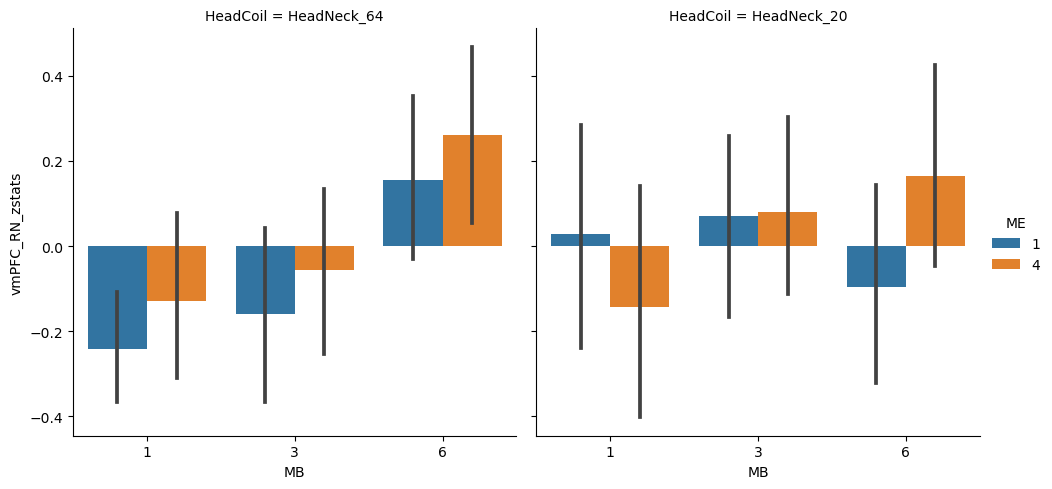

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM     Dependent Variable:     vmPFC_RN_cope
No. Observations:       183         Method:                 REML         
No. Groups:             31          Scale:                  43.0577      
Min. group size:        5           Log-Likelihood:         -599.9786    
Max. group size:        6           Converged:              Yes          
Mean group size:        5.9                                              
-------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      3.608    2.958  1.220 0.223  -2.190  9.406
HeadCoil[T.HeadNeck_64]       -7.999    3.733 -2.143 0.032 -15.315 -0.683
MB                            -0.828    0.746 -1.110 0.267  -2.291  0.635
MB:HeadCoil[T.HeadNeck_64]     1.738    0.946  1.837 0.066  -0.116  3.593
ME                            -2.510    1.004 -2.499 0.012  -4.479 -0.541
ME:HeadCoil[T.HeadNeck_64]     2.831    1.272  2.225 0.026   0.338  5.325
MB:ME                          0.557    0.257  2.171 0.030   0.054  1.060
MB:ME:HeadCoil[T.HeadNeck_64] -0.587    0.325 -1.805 0.071  -1.224  0.050
Group Var                      0.000    0.411                            
=========================================================================

"""

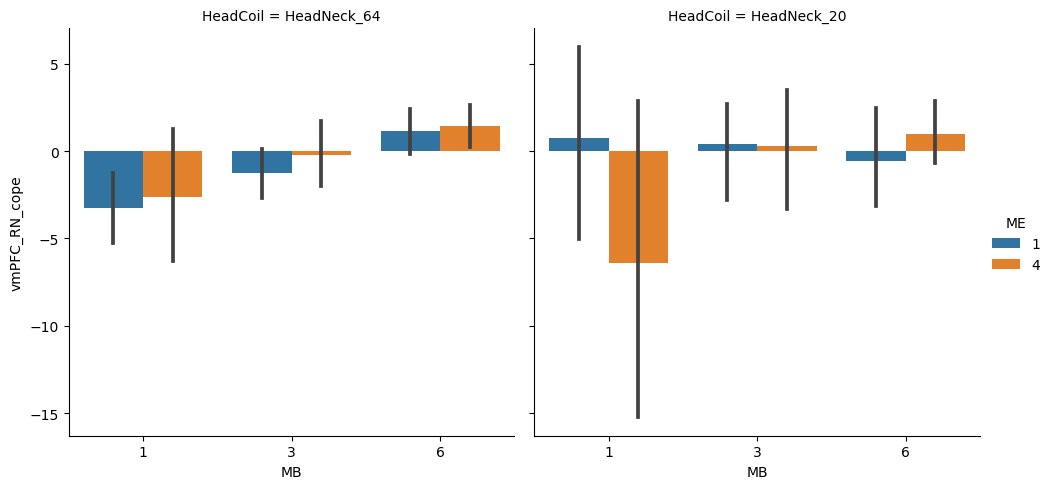

In [10]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('vmPFC_RN_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('vmPFC_RN_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('vmPFC_RN_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='vmPFC_RN_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.savefig("../derivatives/figures/PFC_con_R-N-act_zstat.svg")

plt.show()

print("Results for Cope")
res=smf.mixedlm('vmPFC_RN_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='vmPFC_RN_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/PFC_con_R-N_cope.svg")

plt.show()


# print("Results for VarCope")
# res=smf.mixedlm('VS_Reward_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='VS_Reward_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.show()
#plt.savefig("../derivatives/figures/Reward_VS-act_varcope.svg")


# VS-vmpfc Neu>Pun Connectivity

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: vmPFC_NP_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.2147         
Min. group size:  6       Log-Likelihood:     -83.1862       
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.184     0.161   1.147  0.251  -0.131   0.499
MB             -0.028     0.041  -0.687  0.492  -0.109   0.052
ME              0.010     0.055   0.180  0.857  -0.098   0.118
MB:ME          -0.012     0.014  -0.847  0.397  -0.040   0.016
Group Var       0.000     0.038                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: vmPFC_NP_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              20.8942      
Min. group size:  6       Log-Likelihood:     -334.9780    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     2.344     1.586   1.478  0.139  -0.764   5.452
MB           -0.403     0.405  -0.995  0.320  -1.197   0.391
ME           -0.077     0.544  -0.141  0.888  -1.143   0.989
MB:ME        -0.042     0.139  -0.305  0.760  -0.315   0.230
Group Var     0.000     0.298                               
===========================================================

"""

HeadNeck_20
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: vmPFC_NP_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.2049         
Min. group size:  5       Log-Likelihood:     -51.4326       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.159     0.205  -0.778  0.436  -0.561   0.242
MB              0.066     0.052   1.276  0.202  -0.035   0.167
ME              0.055     0.070   0.794  0.427  -0.081   0.192
MB:ME          -0.026     0.018  -1.458  0.145  -0.061   0.009
Group Var       0.000     0.237                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: vmPFC_NP_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              86.0750      
Min. group size:  5       Log-Likelihood:     -247.7439    
Max. group size:  6       Converged:          No           
Mean group size:  5.8                                      
------------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------
Intercept   -2.407     4.242  -0.567  0.570  -10.721   5.907
MB           0.673     1.069   0.630  0.529   -1.422   2.769
ME           1.244     1.441   0.863  0.388   -1.580   4.067
MB:ME       -0.333     0.372  -0.896  0.370   -1.061   0.395
Group Var    0.000     4.793                                
===========================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    vmPFC_NP_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.2111         
Min. group size:       5          Log-Likelihood:        -134.6408      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.159    0.207 -0.771 0.441 -0.565  0.246
HeadCoil[T.HeadNeck_64]        0.344    0.261  1.317 0.188 -0.168  0.856
MB                             0.066    0.052  1.263 0.207 -0.036  0.168
MB:HeadCoil[T.HeadNeck_64]    -0.094    0.066 -1.422 0.155 -0.224  0.036
ME                             0.055    0.070  0.786 0.432 -0.083  0.193
ME:HeadCoil[T.HeadNeck_64]    -0.045    0.089 -0.509 0.611 -0.220  0.129
MB:ME                         -0.026    0.018 -1.445 0.148 -0.061  0.009
MB:ME:HeadCoil[T.HeadNeck_64]  0.014    0.023  0.616 0.538 -0.031  0.059
Group Var                      0.000    0.037                           
========================================================================

"""

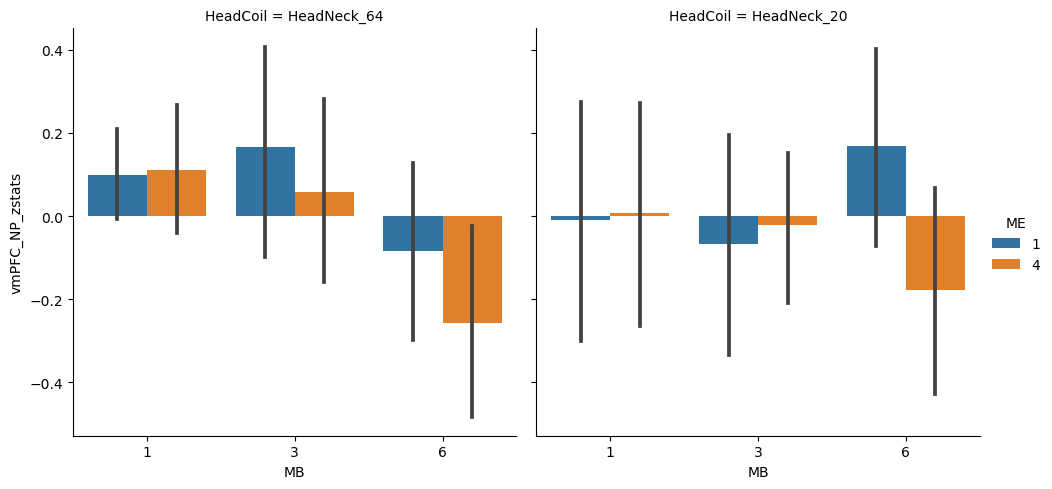

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM     Dependent Variable:     vmPFC_NP_cope
No. Observations:      183         Method:                 REML         
No. Groups:            31          Scale:                  45.1042      
Min. group size:       5           Log-Likelihood:         -604.0416    
Max. group size:       6           Converged:              Yes          
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -2.407    3.026 -0.795 0.426 -8.338  3.524
HeadCoil[T.HeadNeck_64]        4.752    3.819  1.244 0.213 -2.734 12.237
MB                             0.673    0.764  0.881 0.378 -0.824  2.170
MB:HeadCoil[T.HeadNeck_64]    -1.076    0.968 -1.111 0.266 -2.974  0.822
ME                             1.244    1.028  1.209 0.227 -0.772  3.259
ME:HeadCoil[T.HeadNeck_64]    -1.321    1.302 -1.014 0.311 -3.873  1.232
MB:ME                         -0.333    0.263 -1.267 0.205 -0.848  0.182
MB:ME:HeadCoil[T.HeadNeck_64]  0.291    0.333  0.873 0.382 -0.362  0.943
Group Var                      0.000    0.638                           
========================================================================

"""

<Figure size 640x480 with 0 Axes>

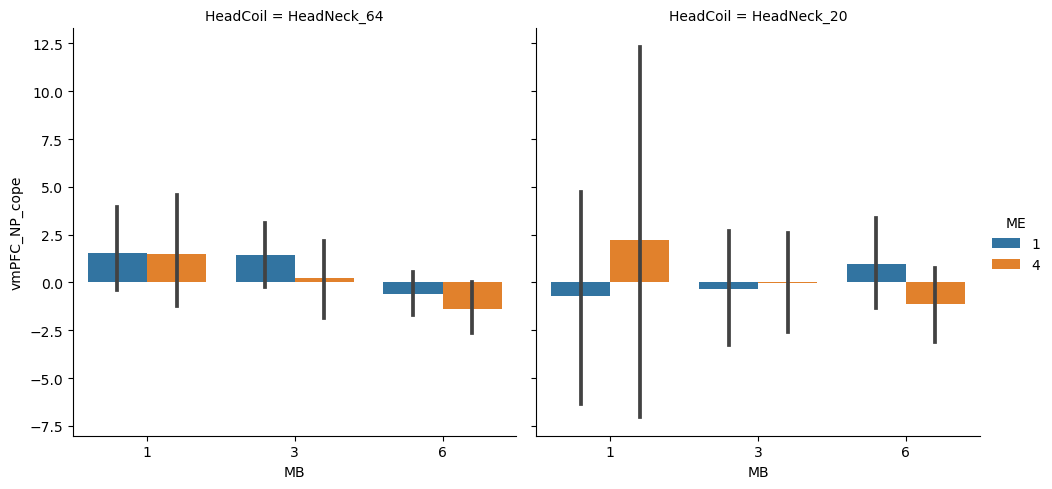

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('vmPFC_NP_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('vmPFC_NP_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('vmPFC_NP_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='vmPFC_NP_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/Reward_VS-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('vmPFC_NP_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='vmPFC_NP_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Reward_VS-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('VS_Reward_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='VS_Reward_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Reward_VS-act_varcope.svg")


# VS-vmpfc Raw Connectivity

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: vmPFC_conn_zstats
No. Observations: 114     Method:             REML             
No. Groups:       19      Scale:              0.3568           
Min. group size:  6       Log-Likelihood:     -119.0600        
Max. group size:  6       Converged:          Yes              
Mean group size:  6.0                                          
-----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept      0.604      0.218   2.775   0.006    0.177    1.030
MB             0.019      0.053   0.359   0.719   -0.085    0.123
ME             0.019      0.071   0.264   0.792   -0.121    0.158
MB:ME          0.004      0.018   0.205   0.838   -0.032    0.039
Group Var      0.084      0.088                                  
===============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: vmPFC_conn_cope
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.1806         
Min. group size:  6       Log-Likelihood:     -78.7979       
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.430     0.151   2.836  0.005   0.133   0.727
MB             -0.031     0.038  -0.831  0.406  -0.105   0.042
ME              0.119     0.051   2.361  0.018   0.020   0.219
MB:ME          -0.016     0.013  -1.262  0.207  -0.042   0.009
Group Var       0.023     0.046                               
=============================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: vmPFC_conn_zstats
No. Observations: 69      Method:             REML             
No. Groups:       12      Scale:              0.1719           
Min. group size:  5       Log-Likelihood:     -49.2345         
Max. group size:  6       Converged:          Yes              
Mean group size:  5.8                                          
-----------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept     0.048      0.193    0.247   0.805   -0.331    0.426
MB            0.143      0.047    3.026   0.002    0.050    0.235
ME            0.131      0.064    2.068   0.039    0.007    0.256
MB:ME        -0.049      0.016   -3.020   0.003   -0.081   -0.017
Group Var     0.027      0.063                                   
===============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: vmPFC_conn_cope
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.2341         
Min. group size:  5       Log-Likelihood:     -57.4235       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.129     0.221   0.583  0.560  -0.304   0.562
MB              0.068     0.055   1.236  0.216  -0.040   0.176
ME              0.229     0.074   3.084  0.002   0.083   0.374
MB:ME          -0.056     0.019  -2.957  0.003  -0.093  -0.019
Group Var       0.014     0.047                               
=============================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:               MixedLM    Dependent Variable:    vmPFC_conn_zstats
No. Observations:    183        Method:                REML             
No. Groups:          31         Scale:                 0.2882           
Min. group size:     5          Log-Likelihood:        -173.8570        
Max. group size:     6          Converged:             Yes              
Mean group size:     5.9                                                
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.048    0.253  0.189 0.850 -0.448  0.543
HeadCoil[T.HeadNeck_64]        0.556    0.319  1.742 0.082 -0.070  1.182
MB                             0.143    0.061  2.336 0.019  0.023  0.263
MB:HeadCoil[T.HeadNeck_64]    -0.124    0.077 -1.598 0.110 -0.276  0.028
ME                             0.132    0.082  1.599 0.110 -0.030  0.293
ME:HeadCoil[T.HeadNeck_64]    -0.113    0.104 -1.083 0.279 -0.317  0.091
MB:ME                         -0.049    0.021 -2.335 0.020 -0.090 -0.008
MB:ME:HeadCoil[T.HeadNeck_64]  0.053    0.027  1.985 0.047  0.001  0.105
Group Var                      0.063    0.059                           
========================================================================

"""

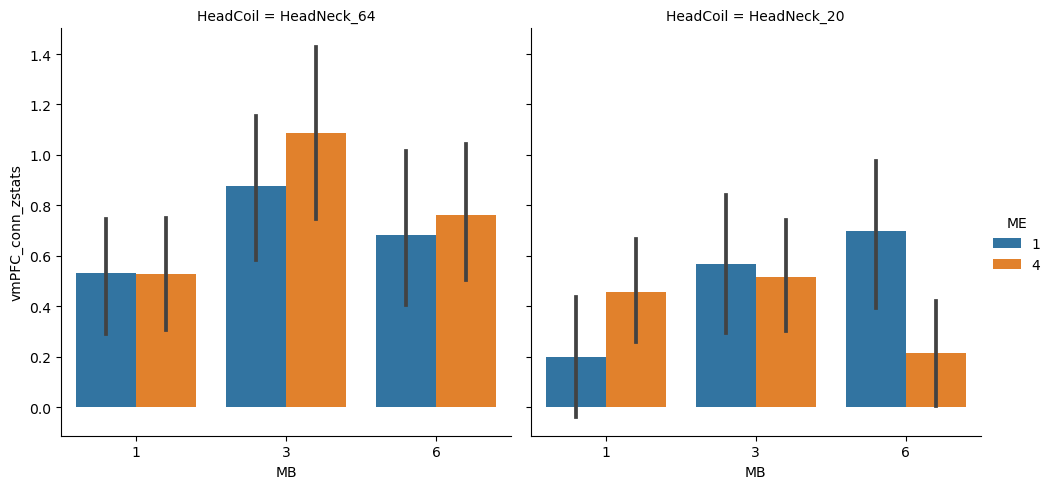

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    vmPFC_conn_cope
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.1982         
Min. group size:       5          Log-Likelihood:        -136.6683      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.129    0.206  0.629 0.529 -0.273  0.532
HeadCoil[T.HeadNeck_64]        0.300    0.259  1.158 0.247 -0.208  0.809
MB                             0.068    0.051  1.343 0.179 -0.031  0.167
MB:HeadCoil[T.HeadNeck_64]    -0.099    0.064 -1.547 0.122 -0.225  0.026
ME                             0.229    0.068  3.357 0.001  0.095  0.363
ME:HeadCoil[T.HeadNeck_64]    -0.110    0.086 -1.269 0.205 -0.279  0.060
MB:ME                         -0.056    0.017 -3.224 0.001 -0.090 -0.022
MB:ME:HeadCoil[T.HeadNeck_64]  0.040    0.022  1.808 0.071 -0.003  0.083
Group Var                      0.023    0.036                           
========================================================================

"""

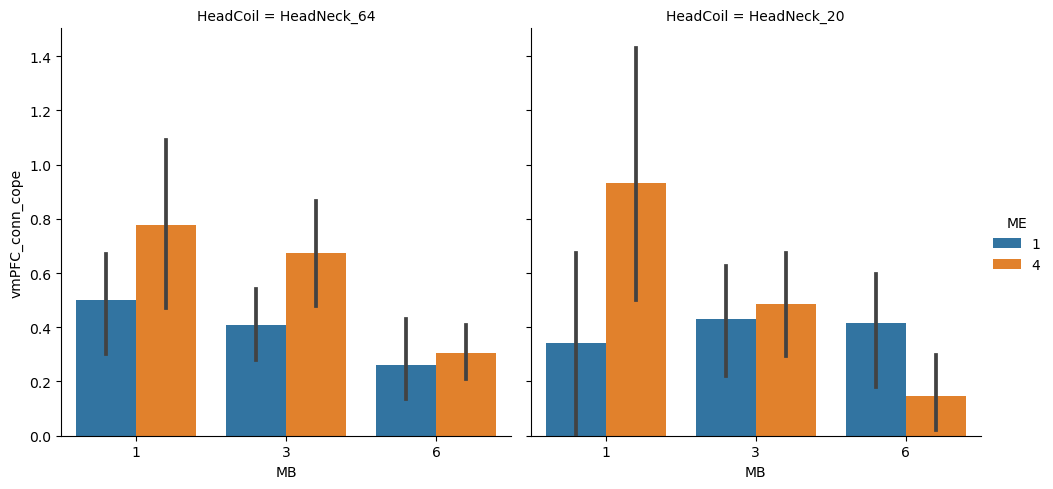

In [9]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('vmPFC_conn_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('vmPFC_conn_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('vmPFC_conn_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='vmPFC_conn_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.savefig("../derivatives/figures/PFC_conn-raw_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('vmPFC_conn_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='vmPFC_conn_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.savefig("../derivatives/figures/PFC_conn-raw_cope.svg")
plt.show()


# print("Results for VarCope")
# res=smf.mixedlm('VS_Reward_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='VS_Reward_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.show()
#plt.savefig("../derivatives/figures/Reward_VS-act_varcope.svg")


# FFA-Face Activiation

In [16]:
masker= NiftiMasker(mask_img=FFA_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope11.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope11.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(FFA_face_cope=copes,
               FFA_face_zstats=zstats,
               FFA_face_varcope=varcopes)
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope17.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat17.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope17.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(FFA_phys_cope=copes,
               FFA_phys_zstats=zstats,
               FFA_phys_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████| 190/190 [02:20<00:00,  1.35it/s]


# Display Face Activation by Acquisition (FFA)

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_face_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.2142         
Min. group size:  6       Log-Likelihood:     -90.7846       
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.085     0.168   0.503  0.615  -0.245   0.415
MB             -0.015     0.041  -0.357  0.721  -0.095   0.066
ME             -0.046     0.055  -0.830  0.407  -0.154   0.062
MB:ME           0.012     0.014   0.888  0.375  -0.015   0.040
Group Var       0.048     0.066                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_face_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              24.0195      
Min. group size:  6       Log-Likelihood:     -348.3402    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     2.248     1.754   1.282  0.200  -1.190   5.686
MB           -0.513     0.434  -1.182  0.237  -1.364   0.338
ME           -1.174     0.583  -2.013  0.044  -2.317  -0.031
MB:ME         0.281     0.149   1.889  0.059  -0.011   0.573
Group Var     3.535     0.561                               
===========================================================

"""

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_face_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.1750         
Min. group size:  5       Log-Likelihood:     -47.4196       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.073     0.190   0.384  0.701  -0.299   0.445
MB             -0.017     0.048  -0.363  0.717  -0.110   0.076
ME             -0.055     0.064  -0.864  0.388  -0.181   0.070
MB:ME           0.012     0.016   0.737  0.461  -0.020   0.044
Group Var       0.007     0.041                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_face_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              55.2932      
Min. group size:  5       Log-Likelihood:     -236.3172    
Max. group size:  6       Converged:          No           
Mean group size:  5.8                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     1.913     3.444   0.556  0.578  -4.836   8.663
MB           -0.467     0.847  -0.552  0.581  -2.127   1.193
ME           -1.913     1.141  -1.677  0.093  -4.148   0.322
MB:ME         0.362     0.291   1.244  0.214  -0.208   0.933
Group Var     6.872     1.167                               
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    FFA_face_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.1997         
Min. group size:       5          Log-Likelihood:        -139.6464      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.074    0.208  0.357 0.721 -0.334  0.483
HeadCoil[T.HeadNeck_64]        0.010    0.263  0.039 0.969 -0.505  0.526
MB                            -0.017    0.051 -0.343 0.732 -0.117  0.082
MB:HeadCoil[T.HeadNeck_64]     0.003    0.064  0.043 0.966 -0.124  0.129
ME                            -0.056    0.069 -0.819 0.413 -0.190  0.078
ME:HeadCoil[T.HeadNeck_64]     0.010    0.087  0.120 0.905 -0.160  0.180
MB:ME                          0.012    0.017  0.691 0.489 -0.022  0.046
MB:ME:HeadCoil[T.HeadNeck_64]  0.000    0.022  0.018 0.986 -0.043  0.044
Group Var                      0.033    0.043                           
========================================================================

"""

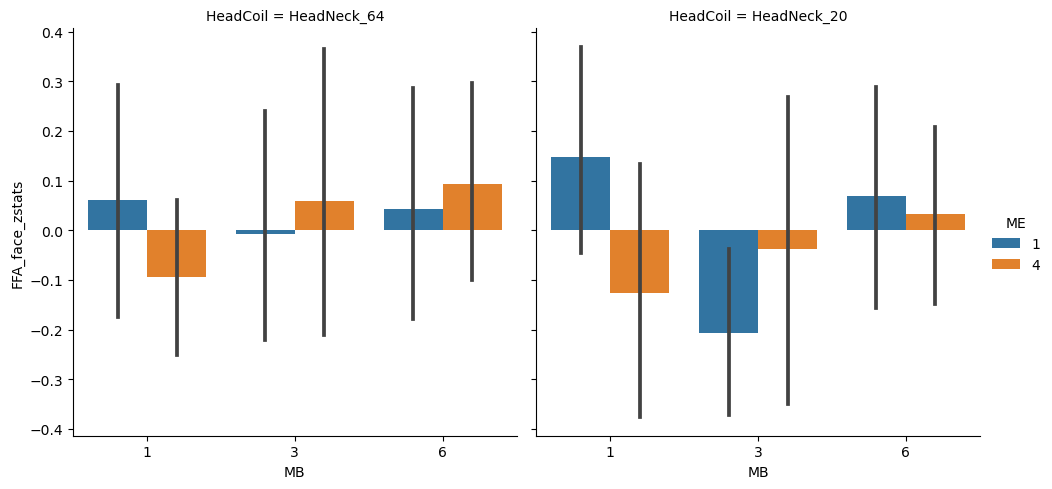

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM     Dependent Variable:     FFA_face_cope
No. Observations:      183         Method:                 REML         
No. Groups:            31          Scale:                  38.5352      
Min. group size:       5           Log-Likelihood:         -592.6371    
Max. group size:       6           Converged:              No           
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      1.763    2.815  0.626 0.531 -3.755  7.282
HeadCoil[T.HeadNeck_64]        0.484    3.553  0.136 0.892 -6.480  7.449
MB                            -0.439    0.706 -0.623 0.534 -1.823  0.944
MB:HeadCoil[T.HeadNeck_64]    -0.074    0.895 -0.082 0.934 -1.828  1.680
ME                            -1.870    0.951 -1.967 0.049 -3.734 -0.007
ME:HeadCoil[T.HeadNeck_64]     0.696    1.204  0.578 0.563 -1.663  3.056
MB:ME                          0.355    0.243  1.464 0.143 -0.120  0.831
MB:ME:HeadCoil[T.HeadNeck_64] -0.074    0.307 -0.241 0.809 -0.677  0.528
Group Var                      1.159    0.279                           
========================================================================

"""

<Figure size 640x480 with 0 Axes>

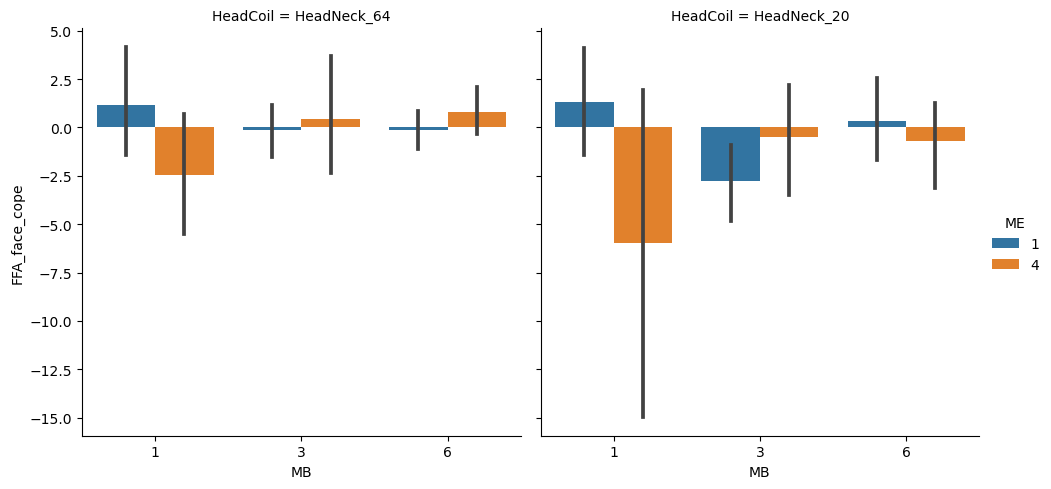

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('FFA_face_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('FFA_face_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('FFA_face_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/Face_FFA-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('FFA_face_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Face_FFA-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('Face_FFA_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Face_FFA_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Face_FFA-act_varcope.svg")


# Display Face Connectivity by Acquisition (FFA)

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_phys_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.3561         
Min. group size:  6       Log-Likelihood:     -115.5887      
Max. group size:  6       Converged:          No             
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.387     0.212   1.828  0.068  -0.028   0.803
MB              0.024     0.053   0.452  0.651  -0.080   0.128
ME             -0.028     0.071  -0.392  0.695  -0.167   0.111
MB:ME           0.008     0.018   0.441  0.659  -0.028   0.044
Group Var       0.039     0.064                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_phys_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              0.2159       
Min. group size:  6       Log-Likelihood:     -85.4880     
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.342     0.163   2.100  0.036   0.023   0.660
MB           -0.037     0.041  -0.890  0.373  -0.117   0.044
ME            0.021     0.055   0.386  0.700  -0.087   0.130
MB:ME         0.004     0.014   0.251  0.802  -0.024   0.031
Group Var     0.009     0.029                               
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_phys_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.2811         
Min. group size:  5       Log-Likelihood:     -65.2043       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.429     0.247   1.739  0.082  -0.055   0.913
MB              0.015     0.060   0.244  0.807  -0.104   0.133
ME             -0.072     0.081  -0.889  0.374  -0.232   0.087
MB:ME           0.001     0.021   0.056  0.955  -0.040   0.042
Group Var       0.044     0.082                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_phys_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              0.2950       
Min. group size:  5       Log-Likelihood:     -64.1832     
Max. group size:  6       Converged:          No           
Mean group size:  5.8                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.437     0.247   1.771  0.077  -0.047   0.920
MB           -0.032     0.062  -0.525  0.600  -0.154   0.089
ME           -0.051     0.083  -0.609  0.543  -0.214   0.112
MB:ME         0.006     0.021   0.297  0.766  -0.035   0.048
Group Var     0.009     0.042                               
===========================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    FFA_phys_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.3527         
Min. group size:       5          Log-Likelihood:        -182.0208      
Max. group size:       6          Converged:             No             
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.440    0.269  1.633 0.103 -0.088  0.968
HeadCoil[T.HeadNeck_64]       -0.052    0.340 -0.154 0.878 -0.719  0.614
MB                             0.013    0.068  0.188 0.851 -0.120  0.145
MB:HeadCoil[T.HeadNeck_64]     0.011    0.086  0.131 0.896 -0.157  0.179
ME                            -0.073    0.091 -0.807 0.420 -0.252  0.105
ME:HeadCoil[T.HeadNeck_64]     0.046    0.115  0.395 0.693 -0.180  0.271
MB:ME                          0.001    0.023  0.058 0.954 -0.044  0.047
MB:ME:HeadCoil[T.HeadNeck_64]  0.007    0.029  0.226 0.821 -0.051  0.064
Group Var                      0.011    0.027                           
========================================================================

"""

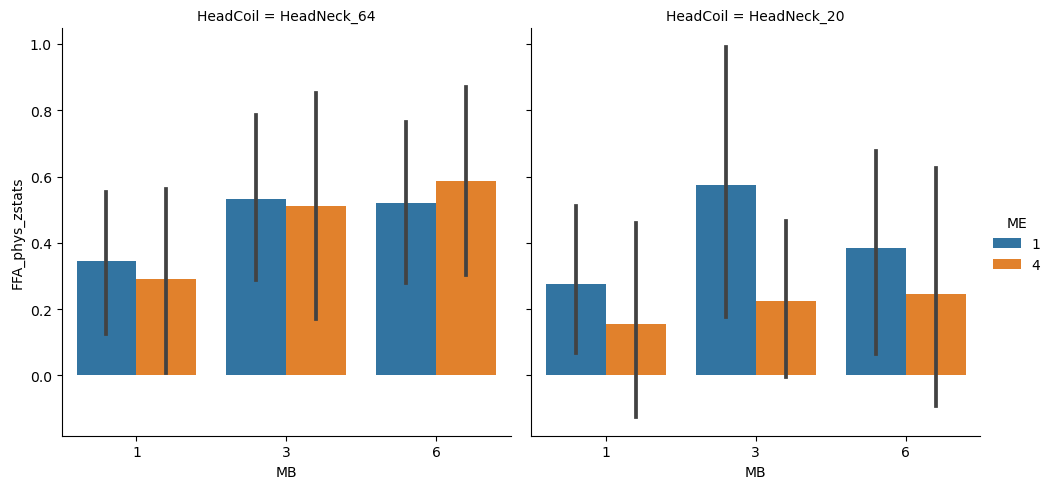

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM     Dependent Variable:     FFA_phys_cope
No. Observations:      183         Method:                 REML         
No. Groups:            31          Scale:                  0.2452       
Min. group size:       5           Log-Likelihood:         -150.6314    
Max. group size:       6           Converged:              No           
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.436    0.225  1.937 0.053 -0.005  0.877
HeadCoil[T.HeadNeck_64]       -0.094    0.284 -0.332 0.740 -0.651  0.462
MB                            -0.032    0.056 -0.572 0.567 -0.143  0.078
MB:HeadCoil[T.HeadNeck_64]    -0.004    0.071 -0.062 0.951 -0.144  0.136
ME                            -0.050    0.076 -0.665 0.506 -0.199  0.098
ME:HeadCoil[T.HeadNeck_64]     0.072    0.096  0.747 0.455 -0.116  0.260
MB:ME                          0.006    0.019  0.325 0.745 -0.032  0.044
MB:ME:HeadCoil[T.HeadNeck_64] -0.003    0.025 -0.112 0.911 -0.051  0.045
Group Var                      0.009    0.024                           
========================================================================

"""

<Figure size 640x480 with 0 Axes>

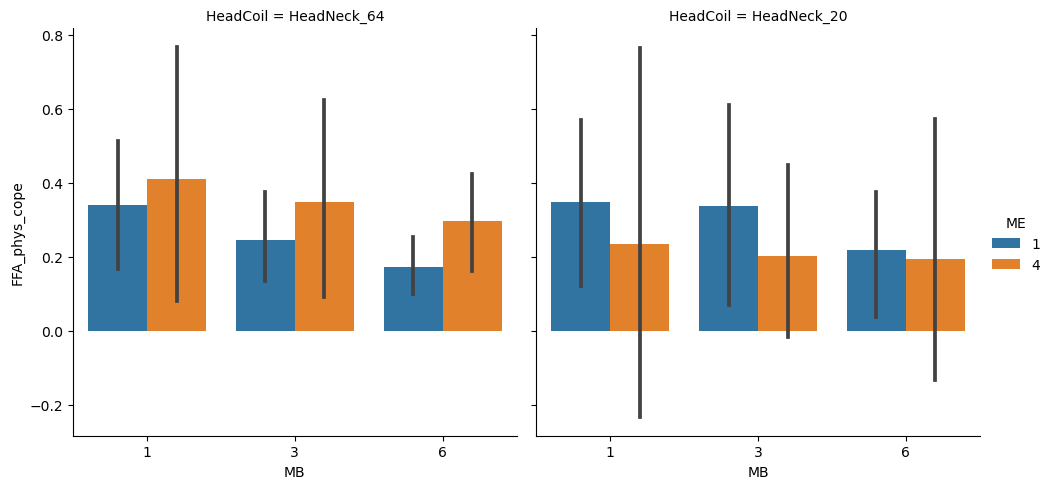

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('FFA_phys_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('FFA_phys_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('FFA_phys_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_phys_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/phys_FFA-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('FFA_phys_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_phys_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/phys_FFA-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('phys_FFA_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='phys_FFA_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/phys_FFA-act_varcope.svg")


# Central Gyrus-Button Activiation

In [20]:
masker= NiftiMasker(mask_img=motor_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(Motor_LR_cope=copes,
               Motor_LR_zstats=zstats,
               Motor_LR_varcope=varcopes)

copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope17.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat17.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope17.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(Motor_phy_cope=copes,
               Motor_phy_zstats=zstats,
               Motor_phy_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████| 190/190 [02:12<00:00,  1.44it/s]


# Display Motor Activation by Acquisition

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.1346         
Min. group size:  6       Log-Likelihood:     -57.5104       
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.354     0.127   2.785  0.005   0.105   0.604
MB             -0.115     0.033  -3.530  0.000  -0.178  -0.051
ME             -0.069     0.044  -1.585  0.113  -0.155   0.016
MB:ME           0.031     0.011   2.805  0.005   0.009   0.053
Group Var       0.000     0.035                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              25.8666      
Min. group size:  6       Log-Likelihood:     -346.7193    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     2.471     1.764   1.401  0.161  -0.987   5.929
MB           -0.689     0.451  -1.530  0.126  -1.573   0.194
ME           -0.170     0.605  -0.281  0.779  -1.356   1.016
MB:ME         0.138     0.155   0.893  0.372  -0.165   0.441
Group Var     0.000     0.343                               
===========================================================

"""

HeadNeck_20
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.1158         
Min. group size:  5       Log-Likelihood:     -34.3526       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.147     0.155   0.950  0.342  -0.157   0.451
MB             -0.047     0.039  -1.209  0.227  -0.123   0.029
ME             -0.013     0.052  -0.247  0.805  -0.115   0.089
MB:ME           0.008     0.013   0.571  0.568  -0.018   0.034
Group Var       0.006     0.037                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              48.7237      
Min. group size:  5       Log-Likelihood:     -229.2497    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    -2.146     3.163  -0.679  0.497  -8.345   4.053
MB            0.160     0.797   0.200  0.841  -1.403   1.722
ME            1.933     1.071   1.806  0.071  -0.165   4.032
MB:ME        -0.286     0.274  -1.043  0.297  -0.823   0.251
Group Var     0.000     1.425                               
===========================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    Motor_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.1299         
Min. group size:       5          Log-Likelihood:        -92.1374       
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.151    0.162  0.931 0.352 -0.167  0.469
HeadCoil[T.HeadNeck_64]        0.203    0.205  0.992 0.321 -0.198  0.605
MB                            -0.048    0.041 -1.164 0.244 -0.128  0.033
MB:HeadCoil[T.HeadNeck_64]    -0.067    0.052 -1.291 0.197 -0.169  0.035
ME                            -0.013    0.055 -0.244 0.807 -0.122  0.095
ME:HeadCoil[T.HeadNeck_64]    -0.056    0.070 -0.798 0.425 -0.193  0.081
MB:ME                          0.008    0.014  0.558 0.577 -0.020  0.035
MB:ME:HeadCoil[T.HeadNeck_64]  0.023    0.018  1.312 0.190 -0.012  0.058
Group Var                      0.000    0.020                           
========================================================================

"""

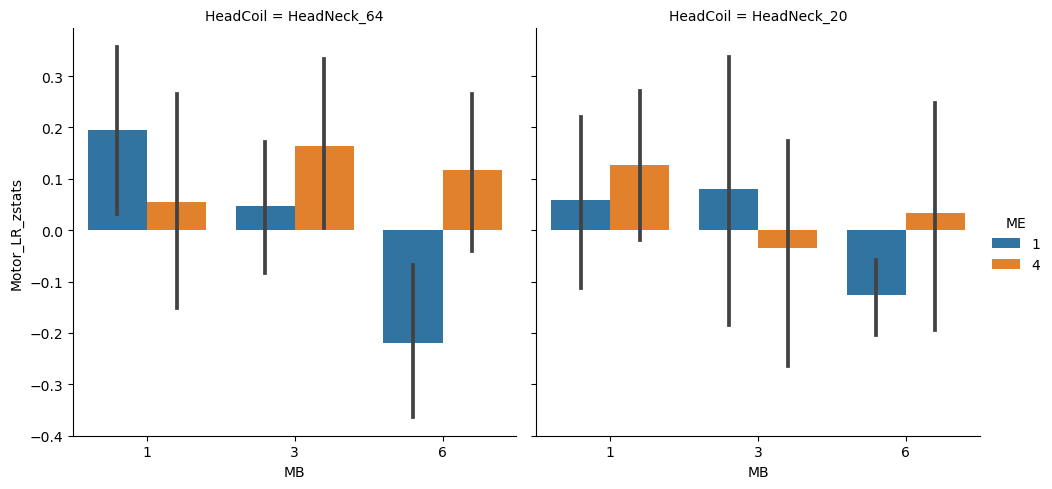

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM     Dependent Variable:     Motor_LR_cope
No. Observations:      183         Method:                 REML         
No. Groups:            31          Scale:                  34.3564      
Min. group size:       5           Log-Likelihood:         -580.2251    
Max. group size:       6           Converged:              Yes          
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -2.146    2.641 -0.812 0.417 -7.323  3.031
HeadCoil[T.HeadNeck_64]        4.617    3.333  1.385 0.166 -1.916 11.151
MB                             0.160    0.667  0.240 0.811 -1.147  1.466
MB:HeadCoil[T.HeadNeck_64]    -0.849    0.845 -1.005 0.315 -2.505  0.807
ME                             1.933    0.897  2.155 0.031  0.175  3.692
ME:HeadCoil[T.HeadNeck_64]    -2.103    1.136 -1.851 0.064 -4.330  0.124
MB:ME                         -0.286    0.229 -1.246 0.213 -0.735  0.164
MB:ME:HeadCoil[T.HeadNeck_64]  0.424    0.290  1.460 0.144 -0.145  0.993
Group Var                      0.000    0.417                           
========================================================================

"""

<Figure size 640x480 with 0 Axes>

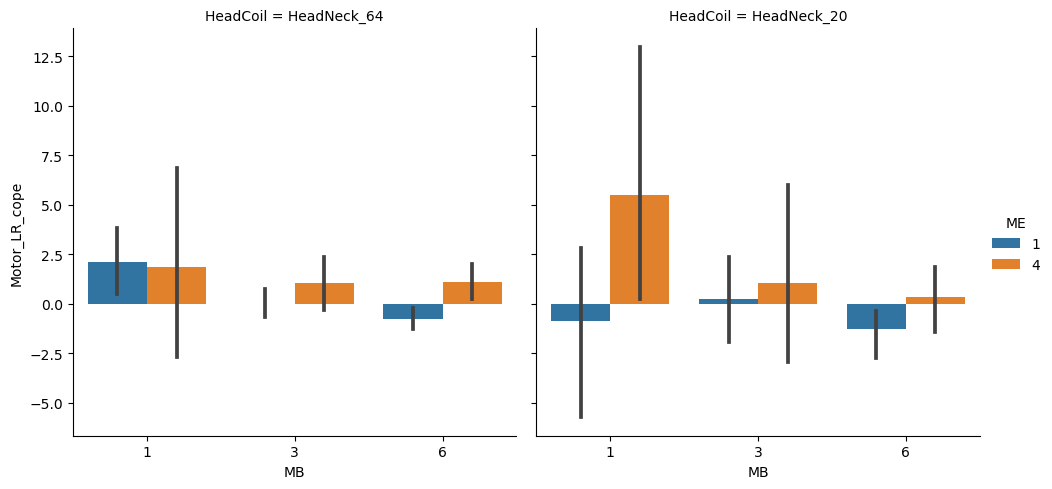

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('Motor_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('Motor_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('Motor_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('Motor_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_varcope.svg")

# Display Motor connectivity by Acquisition

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Motor_phy_zstats
No. Observations: 114     Method:             REML            
No. Groups:       19      Scale:              0.2140          
Min. group size:  6       Log-Likelihood:     -83.8325        
Max. group size:  6       Converged:          Yes             
Mean group size:  6.0                                         
----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------
Intercept    0.158      0.161    0.982   0.326   -0.157    0.474
MB           0.072      0.041    1.765   0.078   -0.008    0.153
ME           0.040      0.055    0.732   0.464   -0.068    0.148
MB:ME       -0.012      0.014   -0.858   0.391   -0.040    0.015
Group Var    0.003      0.031                                   
==============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: Motor_phy_cope
No. Observations: 114     Method:             REML          
No. Groups:       19      Scale:              0.0806        
Min. group size:  6       Log-Likelihood:     -29.3099      
Max. group size:  6       Converged:          Yes           
Mean group size:  6.0                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.094     0.098   0.956  0.339  -0.099   0.287
MB             0.007     0.025   0.272  0.785  -0.042   0.056
ME             0.061     0.034   1.810  0.070  -0.005   0.127
MB:ME         -0.010     0.009  -1.126  0.260  -0.027   0.007
Group Var      0.000     0.021                               
============================================================

"""

HeadNeck_20
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Motor_phy_zstats
No. Observations: 69      Method:             REML            
No. Groups:       12      Scale:              0.1532          
Min. group size:  5       Log-Likelihood:     -41.9780        
Max. group size:  6       Converged:          Yes             
Mean group size:  5.8                                         
----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------
Intercept    0.240      0.172    1.396   0.163   -0.097    0.578
MB           0.062      0.044    1.415   0.157   -0.024    0.148
ME          -0.009      0.059   -0.153   0.878   -0.126    0.107
MB:ME       -0.009      0.015   -0.594   0.553   -0.039    0.021
Group Var    0.000                                              
==============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: Motor_phy_cope
No. Observations: 69      Method:             REML          
No. Groups:       12      Scale:              0.1974        
Min. group size:  5       Log-Likelihood:     -50.4956      
Max. group size:  6       Converged:          Yes           
Mean group size:  5.8                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.287     0.202   1.421  0.155  -0.109   0.684
MB            -0.001     0.051  -0.020  0.984  -0.100   0.098
ME            -0.009     0.068  -0.139  0.890  -0.143   0.124
MB:ME         -0.002     0.017  -0.122  0.903  -0.036   0.032
Group Var      0.002     0.042                               
============================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM    Dependent Variable:    Motor_phy_zstats
No. Observations:     183        Method:                REML            
No. Groups:           31         Scale:                 0.1935          
Min. group size:      5          Log-Likelihood:        -127.0513       
Max. group size:      6          Converged:             Yes             
Mean group size:      5.9                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.240    0.198  1.213 0.225 -0.148  0.629
HeadCoil[T.HeadNeck_64]       -0.082    0.250 -0.329 0.742 -0.573  0.408
MB                             0.062    0.050  1.245 0.213 -0.036  0.160
MB:HeadCoil[T.HeadNeck_64]     0.010    0.063  0.159 0.874 -0.114  0.134
ME                            -0.009    0.067 -0.135 0.892 -0.141  0.123
ME:HeadCoil[T.HeadNeck_64]     0.049    0.085  0.579 0.563 -0.118  0.217
MB:ME                         -0.009    0.017 -0.528 0.598 -0.043  0.025
MB:ME:HeadCoil[T.HeadNeck_64] -0.003    0.022 -0.137 0.891 -0.046  0.040
Group Var                      0.000    0.024                           
========================================================================

"""

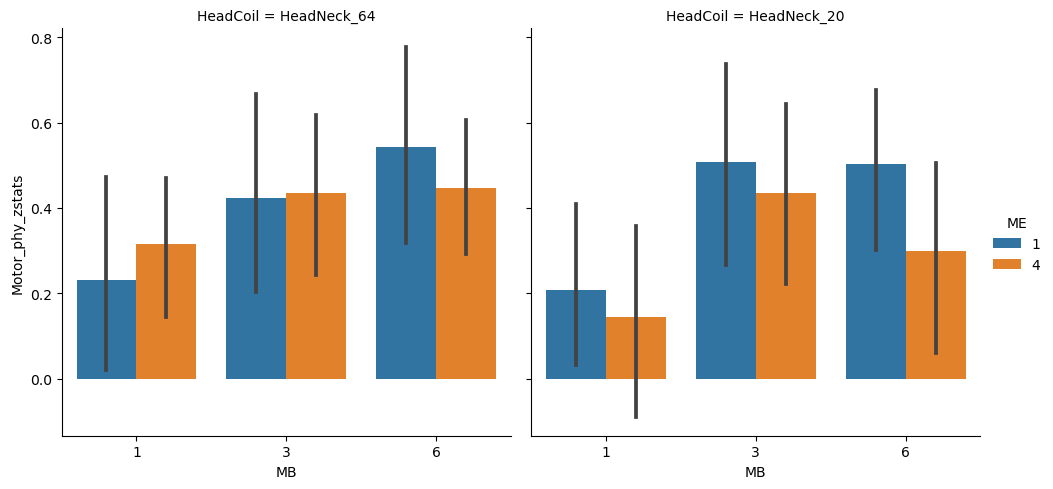

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM     Dependent Variable:     Motor_phy_cope
No. Observations:     183         Method:                 REML          
No. Groups:           31          Scale:                  0.1246        
Min. group size:      5           Log-Likelihood:         -88.5466      
Max. group size:      6           Converged:              Yes           
Mean group size:      5.9                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.290    0.160  1.815 0.070 -0.023  0.603
HeadCoil[T.HeadNeck_64]       -0.196    0.201 -0.973 0.331 -0.591  0.199
MB                            -0.001    0.040 -0.037 0.970 -0.080  0.077
MB:HeadCoil[T.HeadNeck_64]     0.008    0.051  0.164 0.870 -0.092  0.108
ME                            -0.010    0.054 -0.187 0.852 -0.116  0.096
ME:HeadCoil[T.HeadNeck_64]     0.071    0.069  1.040 0.298 -0.063  0.206
MB:ME                         -0.002    0.014 -0.147 0.883 -0.029  0.025
MB:ME:HeadCoil[T.HeadNeck_64] -0.008    0.017 -0.439 0.661 -0.042  0.027
Group Var                      0.000    0.020                           
========================================================================

"""

<Figure size 640x480 with 0 Axes>

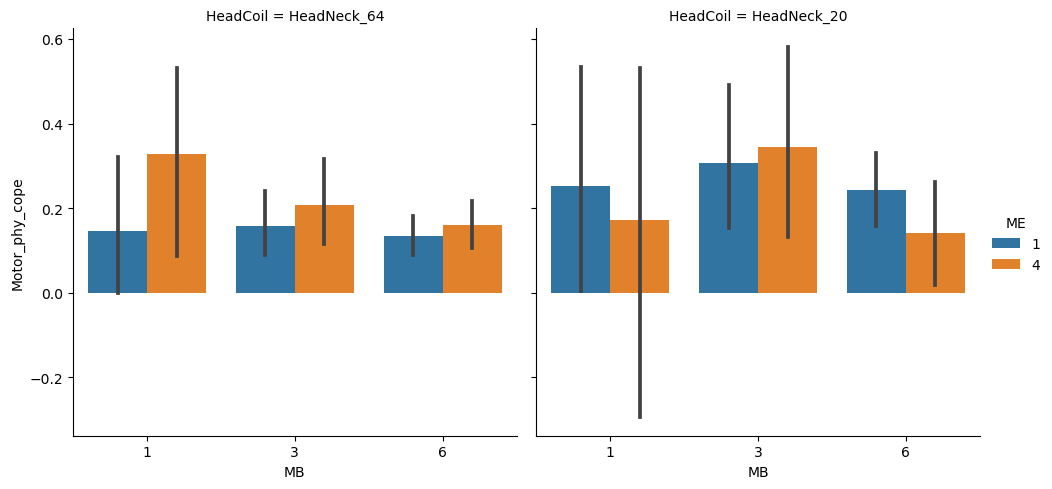

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [22]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('Motor_phy_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('Motor_phy_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('Motor_phy_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_phy_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('Motor_phy_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_phy_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Motor_phy-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_varcope.svg")

# Central ICerbt-Button Activiation

In [29]:
masker= NiftiMasker(mask_img=iCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(iCerb_LR_cope=copes,
               iCerb_LR_zstats=zstats,
               iCerb_LR_varcope=varcopes)
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope17.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat17.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope17.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(iCerb_phys_cope=copes,
               iCerb_phys_zstats=zstats,
               iCerb_phys_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████| 190/190 [02:13<00:00,  1.42it/s]


# Display Inferior Cerebellar Activation by Acquisition

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: iCerb_LR_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.1594         
Min. group size:  6       Log-Likelihood:     -68.7597       
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.269     0.140   1.925  0.054  -0.005   0.543
MB             -0.088     0.035  -2.495  0.013  -0.158  -0.019
ME             -0.045     0.048  -0.937  0.349  -0.138   0.049
MB:ME           0.016     0.012   1.308  0.191  -0.008   0.040
Group Var       0.006     0.030                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: iCerb_LR_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              24.1207      
Min. group size:  6       Log-Likelihood:     -342.8757    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     2.736     1.704   1.606  0.108  -0.603   6.075
MB           -0.775     0.435  -1.782  0.075  -1.628   0.078
ME           -0.257     0.584  -0.440  0.660  -1.402   0.889
MB:ME         0.135     0.149   0.904  0.366  -0.158   0.427
Group Var     0.000     0.326                               
===========================================================

"""

HeadNeck_20
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: iCerb_LR_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.1071         
Min. group size:  5       Log-Likelihood:     -33.6870       
Max. group size:  6       Converged:          No             
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.227     0.152   1.496  0.135  -0.071   0.525
MB             -0.056     0.037  -1.515  0.130  -0.129   0.017
ME             -0.101     0.050  -2.008  0.045  -0.199  -0.002
MB:ME           0.021     0.013   1.676  0.094  -0.004   0.047
Group Var       0.016     0.059                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: iCerb_LR_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              46.3468      
Min. group size:  5       Log-Likelihood:     -228.1672    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     2.589     3.078   0.841  0.400  -3.443   8.621
MB           -0.760     0.774  -0.983  0.326  -2.277   0.756
ME           -1.401     1.042  -1.345  0.179  -3.444   0.641
MB:ME         0.319     0.266   1.199  0.230  -0.202   0.841
Group Var     0.839     0.588                               
===========================================================

"""

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    iCerb_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.1413         
Min. group size:       5          Log-Likelihood:        -103.4856      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.229    0.171  1.340 0.180 -0.106  0.565
HeadCoil[T.HeadNeck_64]        0.040    0.216  0.183 0.855 -0.384  0.463
MB                            -0.057    0.043 -1.328 0.184 -0.141  0.027
MB:HeadCoil[T.HeadNeck_64]    -0.031    0.054 -0.581 0.561 -0.138  0.075
ME                            -0.101    0.058 -1.756 0.079 -0.214  0.012
ME:HeadCoil[T.HeadNeck_64]     0.057    0.073  0.776 0.438 -0.086  0.199
MB:ME                          0.021    0.015  1.461 0.144 -0.007  0.050
MB:ME:HeadCoil[T.HeadNeck_64] -0.006    0.019 -0.301 0.763 -0.042  0.031
Group Var                      0.008    0.024                           
========================================================================

"""

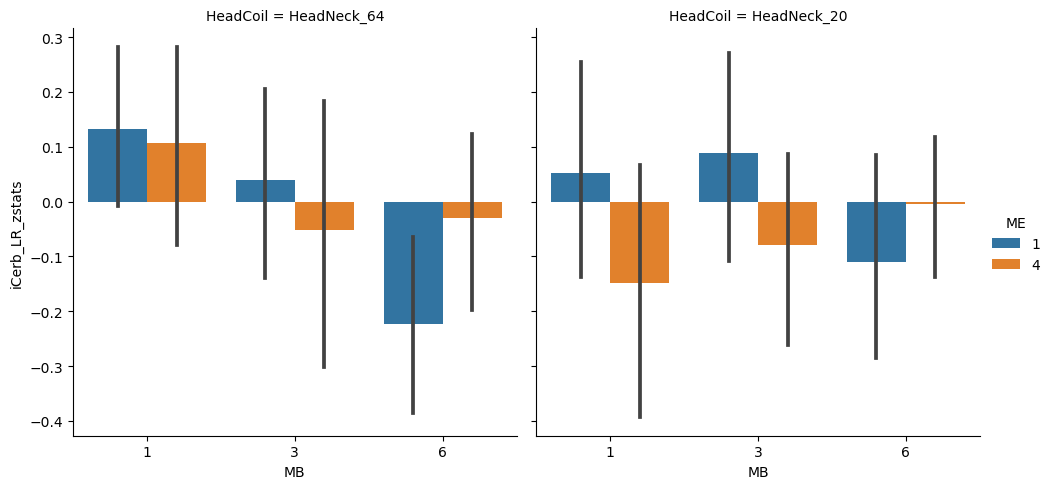

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM     Dependent Variable:     iCerb_LR_cope
No. Observations:      183         Method:                 REML         
No. Groups:            31          Scale:                  32.6163      
Min. group size:       5           Log-Likelihood:         -575.8459    
Max. group size:       6           Converged:              Yes          
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      2.597    2.572  1.010 0.313 -2.445  7.638
HeadCoil[T.HeadNeck_64]        0.139    3.247  0.043 0.966 -6.225  6.504
MB                            -0.762    0.649 -1.174 0.240 -2.034  0.510
MB:HeadCoil[T.HeadNeck_64]    -0.013    0.823 -0.016 0.987 -1.626  1.600
ME                            -1.404    0.874 -1.607 0.108 -3.116  0.309
ME:HeadCoil[T.HeadNeck_64]     1.147    1.107  1.036 0.300 -1.023  3.317
MB:ME                          0.320    0.223  1.434 0.152 -0.117  0.758
MB:ME:HeadCoil[T.HeadNeck_64] -0.185    0.283 -0.655 0.513 -0.739  0.369
Group Var                      0.065    0.277                           
========================================================================

"""

<Figure size 640x480 with 0 Axes>

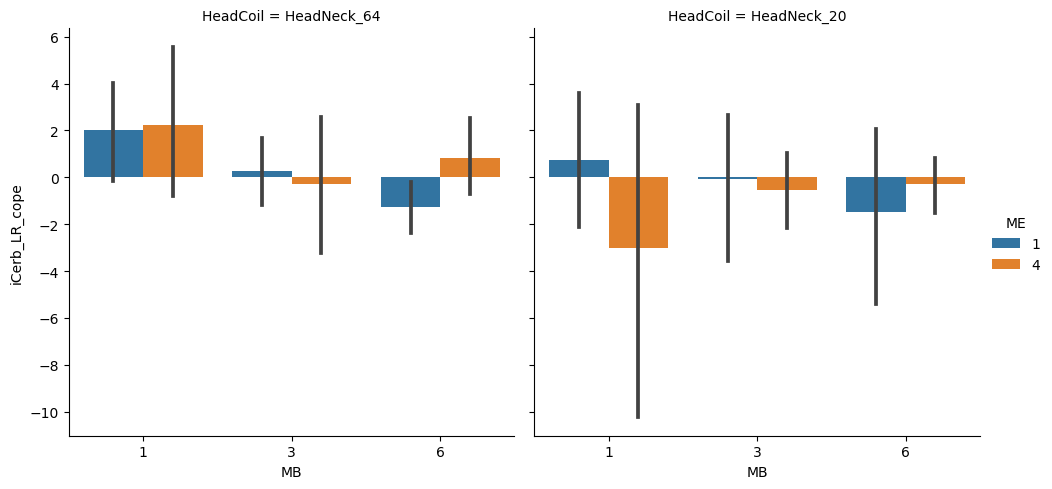

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [30]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('iCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figuresiCerb_LR-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('iCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/iCerb_LR-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_varcope.svg")


# Display Inferior Cerebellar Activation by Acquisition

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: iCerb_phys_zstats
No. Observations: 114     Method:             REML             
No. Groups:       19      Scale:              0.1619           
Min. group size:  6       Log-Likelihood:     -72.4788         
Max. group size:  6       Converged:          No               
Mean group size:  6.0                                          
-----------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept     0.150      0.143    1.046   0.295   -0.131    0.430
MB            0.080      0.036    2.239   0.025    0.010    0.150
ME            0.002      0.048    0.044   0.965   -0.092    0.096
MB:ME        -0.009      0.012   -0.774   0.439   -0.033    0.014
Group Var     0.019      0.045                                   
===============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: iCerb_phys_cope
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.1083         
Min. group size:  6       Log-Likelihood:     -48.4331       
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.250     0.116   2.159  0.031   0.023   0.477
MB             -0.010     0.029  -0.332  0.740  -0.067   0.047
ME             -0.014     0.039  -0.345  0.730  -0.090   0.063
MB:ME           0.004     0.010   0.374  0.708  -0.016   0.023
Group Var       0.007     0.028                               
=============================================================

"""

HeadNeck_20
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: iCerb_phys_zstats
No. Observations: 69      Method:             REML             
No. Groups:       12      Scale:              0.1396           
Min. group size:  5       Log-Likelihood:     -38.9633         
Max. group size:  6       Converged:          Yes              
Mean group size:  5.8                                          
-----------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept     0.174      0.168    1.035   0.301   -0.156    0.504
MB            0.029      0.042    0.693   0.488   -0.054    0.113
ME            0.005      0.057    0.092   0.926   -0.107    0.117
MB:ME        -0.007      0.015   -0.474   0.636   -0.036    0.022
Group Var     0.000      0.064                                   
===============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: iCerb_phys_cope
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.1624         
Min. group size:  5       Log-Likelihood:     -43.8790       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.229     0.182   1.262  0.207  -0.127   0.585
MB             -0.003     0.046  -0.069  0.945  -0.093   0.087
ME              0.033     0.062   0.536  0.592  -0.088   0.154
MB:ME          -0.008     0.016  -0.489  0.625  -0.039   0.023
Group Var       0.000     0.043                               
=============================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:               MixedLM    Dependent Variable:    iCerb_phys_zstats
No. Observations:    183        Method:                REML             
No. Groups:          31         Scale:                 0.1590           
Min. group size:     5          Log-Likelihood:        -112.5884        
Max. group size:     6          Converged:             Yes              
Mean group size:     5.9                                                
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.174    0.181  0.964 0.335 -0.180  0.529
HeadCoil[T.HeadNeck_64]       -0.025    0.228 -0.108 0.914 -0.472  0.423
MB                             0.029    0.045  0.646 0.518 -0.060  0.118
MB:HeadCoil[T.HeadNeck_64]     0.051    0.057  0.879 0.379 -0.062  0.163
ME                             0.005    0.061  0.079 0.937 -0.115  0.124
ME:HeadCoil[T.HeadNeck_64]    -0.003    0.077 -0.035 0.972 -0.154  0.149
MB:ME                         -0.007    0.016 -0.434 0.664 -0.037  0.024
MB:ME:HeadCoil[T.HeadNeck_64] -0.003    0.020 -0.137 0.891 -0.041  0.036
Group Var                      0.006    0.023                           
========================================================================

"""

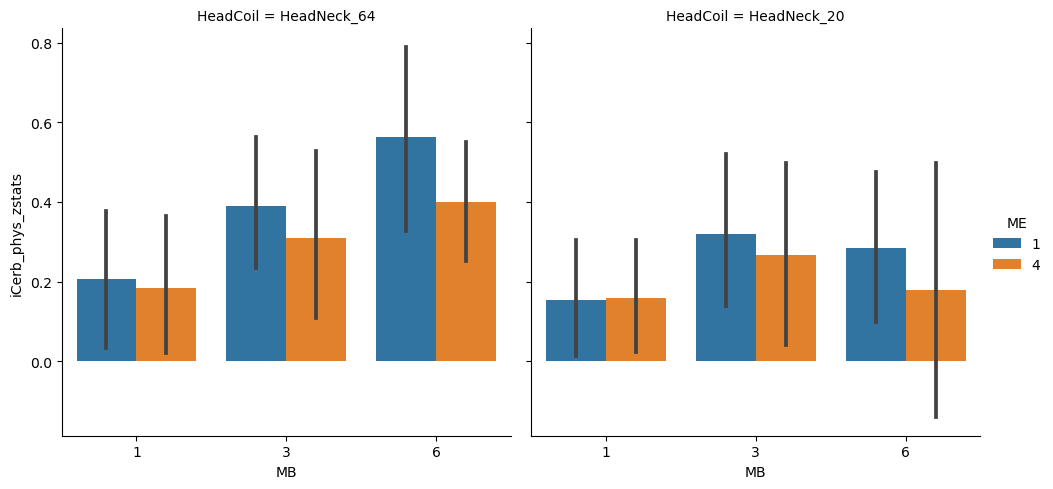

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    iCerb_phys_cope
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.1308         
Min. group size:       5          Log-Likelihood:        -93.9376       
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.230    0.163  1.408 0.159 -0.090  0.550
HeadCoil[T.HeadNeck_64]        0.020    0.206  0.096 0.923 -0.384  0.424
MB                            -0.003    0.041 -0.082 0.935 -0.084  0.077
MB:HeadCoil[T.HeadNeck_64]    -0.006    0.052 -0.121 0.904 -0.108  0.096
ME                             0.033    0.055  0.590 0.555 -0.076  0.141
ME:HeadCoil[T.HeadNeck_64]    -0.046    0.070 -0.659 0.510 -0.184  0.091
MB:ME                         -0.008    0.014 -0.537 0.591 -0.035  0.020
MB:ME:HeadCoil[T.HeadNeck_64]  0.011    0.018  0.633 0.527 -0.024  0.046
Group Var                      0.002    0.019                           
========================================================================

"""

<Figure size 640x480 with 0 Axes>

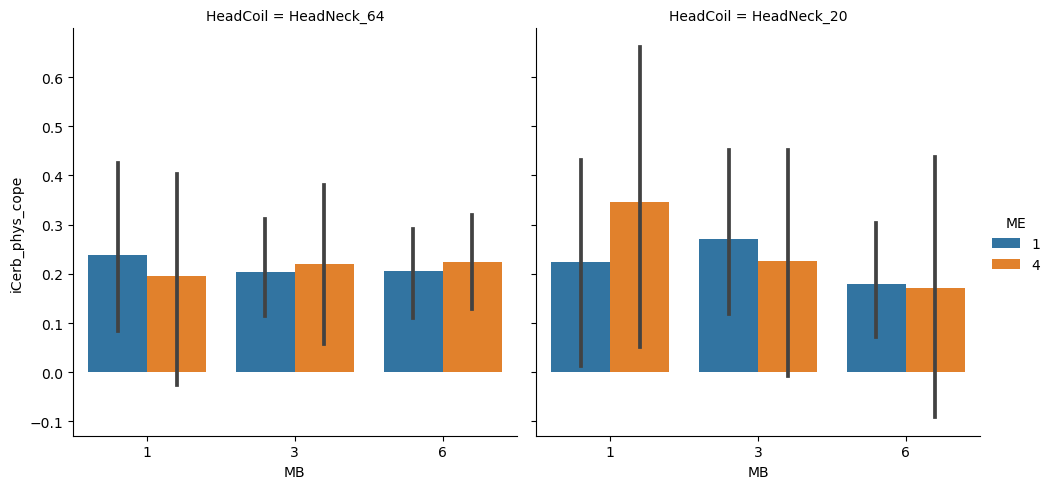

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [31]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('iCerb_phys_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('iCerb_phys_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('iCerb_phys_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_phys_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/iCerb_phys-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('iCerb_phys_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_phys_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/iCerb_phys-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/iCerb_phys-act_varcope.svg")


# SCerb-Button Activiation

In [32]:
masker= NiftiMasker(mask_img=sCerb_mask)
                                      
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(sCerb_LR_cope=copes,
               sCerb_LR_zstats=zstats,
               sCerb_LR_varcope=varcopes)
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope17.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat17.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope17.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(sCerb_phys_cope=copes,
               sCerb_phys_zstats=zstats,
               sCerb_phys_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████| 190/190 [02:17<00:00,  1.38it/s]


# sCerb motor-conn

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: sCerb_LR_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.1052         
Min. group size:  6       Log-Likelihood:     -43.9462       
Max. group size:  6       Converged:          No             
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.311     0.113   2.764  0.006   0.091   0.532
MB             -0.095     0.029  -3.321  0.001  -0.152  -0.039
ME             -0.094     0.039  -2.445  0.014  -0.170  -0.019
MB:ME           0.033     0.010   3.300  0.001   0.013   0.052
Group Var       0.000                                         
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: sCerb_LR_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              22.6697      
Min. group size:  6       Log-Likelihood:     -339.4637    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     3.955     1.652   2.394  0.017   0.718   7.192
MB           -1.060     0.422  -2.514  0.012  -1.887  -0.234
ME           -1.502     0.567  -2.650  0.008  -2.612  -0.391
MB:ME         0.427     0.145   2.953  0.003   0.144   0.711
Group Var     0.000                                         
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: sCerb_LR_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.0822         
Min. group size:  5       Log-Likelihood:     -24.7896       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.111     0.133   0.839  0.401  -0.149   0.372
MB             -0.018     0.033  -0.564  0.573  -0.082   0.046
ME             -0.032     0.044  -0.722  0.470  -0.118   0.054
MB:ME           0.003     0.011   0.278  0.781  -0.019   0.025
Group Var       0.011     0.040                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: sCerb_LR_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              41.5319      
Min. group size:  5       Log-Likelihood:     -227.6288    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.594     3.002   0.198  0.843  -5.290   6.477
MB            0.007     0.733   0.009  0.993  -1.431   1.444
ME           -0.201     0.988  -0.203  0.839  -2.137   1.735
MB:ME         0.033     0.252   0.133  0.895  -0.461   0.528
Group Var     6.625     0.995                               
===========================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    sCerb_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.1005         
Min. group size:       5          Log-Likelihood:        -69.7405       
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.110    0.143  0.768 0.442 -0.170  0.389
HeadCoil[T.HeadNeck_64]        0.201    0.180  1.117 0.264 -0.152  0.555
MB                            -0.018    0.036 -0.509 0.610 -0.089  0.052
MB:HeadCoil[T.HeadNeck_64]    -0.077    0.046 -1.687 0.092 -0.167  0.012
ME                            -0.032    0.049 -0.651 0.515 -0.127  0.063
ME:HeadCoil[T.HeadNeck_64]    -0.063    0.061 -1.021 0.307 -0.183  0.058
MB:ME                          0.003    0.012  0.274 0.784 -0.021  0.028
MB:ME:HeadCoil[T.HeadNeck_64]  0.029    0.016  1.856 0.063 -0.002  0.060
Group Var                      0.000    0.019                           
========================================================================

"""

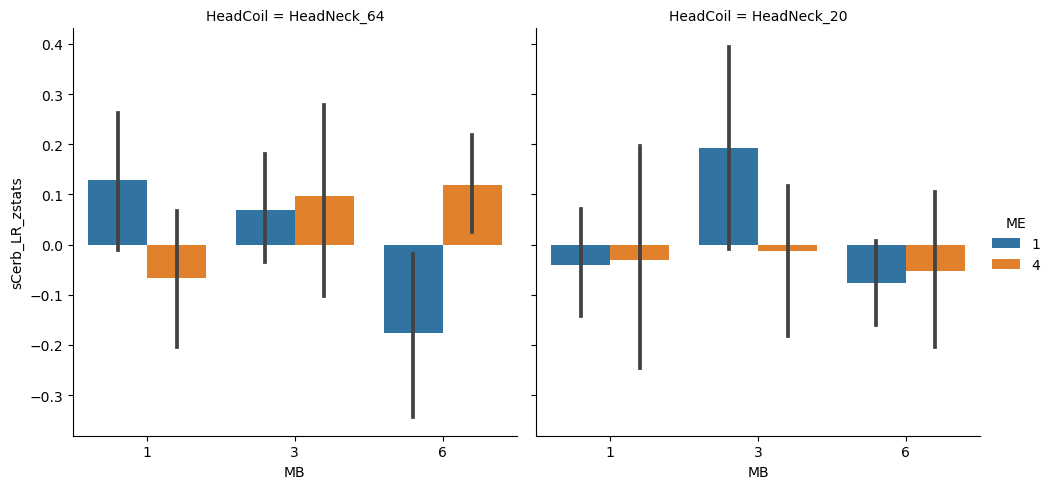

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM     Dependent Variable:     sCerb_LR_cope
No. Observations:      183         Method:                 REML         
No. Groups:            31          Scale:                  31.0740      
Min. group size:       5           Log-Likelihood:         -574.0389    
Max. group size:       6           Converged:              Yes          
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.586    2.528  0.232 0.817 -4.369  5.542
HeadCoil[T.HeadNeck_64]        3.369    3.192  1.055 0.291 -2.887  9.624
MB                             0.002    0.634  0.003 0.998 -1.240  1.244
MB:HeadCoil[T.HeadNeck_64]    -1.062    0.803 -1.322 0.186 -2.637  0.512
ME                            -0.209    0.853 -0.245 0.806 -1.882  1.463
ME:HeadCoil[T.HeadNeck_64]    -1.292    1.081 -1.196 0.232 -3.411  0.826
MB:ME                          0.041    0.218  0.189 0.850 -0.386  0.469
MB:ME:HeadCoil[T.HeadNeck_64]  0.386    0.276  1.398 0.162 -0.155  0.927
Group Var                      1.035    0.326                           
========================================================================

"""

<Figure size 640x480 with 0 Axes>

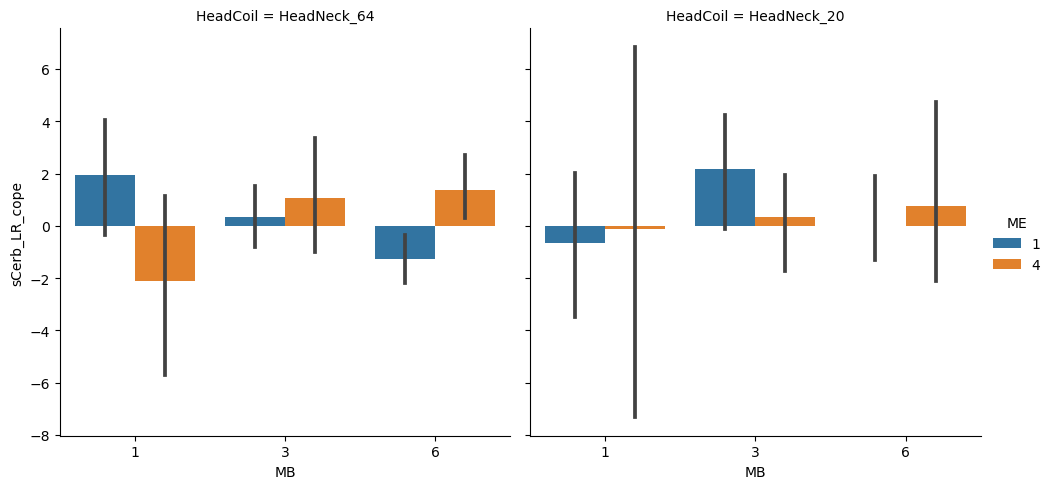

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('sCerb_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('sCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('sCerb_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='sCerb_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/sCerb_LR-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('sCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='sCerb_LR_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/sCerb_LR-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/sCerb_LR-act_varcope.svg")


HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: sCerb_phys_zstats
No. Observations: 114     Method:             REML             
No. Groups:       19      Scale:              0.1238           
Min. group size:  6       Log-Likelihood:     -56.6111         
Max. group size:  6       Converged:          No               
Mean group size:  6.0                                          
-----------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept     0.296      0.124    2.384   0.017    0.053    0.540
MB            0.025      0.031    0.808   0.419   -0.036    0.086
ME           -0.041      0.042   -0.987   0.324   -0.123    0.041
MB:ME         0.006      0.011    0.550   0.583   -0.015    0.027
Group Var     0.010      0.031                                   
===============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: sCerb_phys_cope
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.1023         
Min. group size:  6       Log-Likelihood:     -43.4098       
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.355     0.111   3.184  0.001   0.136   0.573
MB             -0.035     0.028  -1.240  0.215  -0.091   0.020
ME             -0.026     0.038  -0.679  0.497  -0.100   0.049
MB:ME           0.009     0.010   0.972  0.331  -0.010   0.029
Group Var       0.002     0.022                               
=============================================================

"""

HeadNeck_20
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: sCerb_phys_zstats
No. Observations: 69      Method:             REML             
No. Groups:       12      Scale:              0.1373           
Min. group size:  5       Log-Likelihood:     -38.4108         
Max. group size:  6       Converged:          No               
Mean group size:  5.8                                          
-----------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept     0.090      0.167    0.539   0.590   -0.237    0.416
MB            0.067      0.042    1.588   0.112   -0.016    0.149
ME            0.003      0.057    0.056   0.955   -0.108    0.114
MB:ME        -0.013      0.014   -0.926   0.354   -0.042    0.015
Group Var     0.000                                              
===============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: sCerb_phys_cope
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.2185         
Min. group size:  5       Log-Likelihood:     -53.5140       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.216     0.213   1.013  0.311  -0.201   0.632
MB              0.020     0.053   0.366  0.715  -0.085   0.124
ME             -0.003     0.072  -0.038  0.970  -0.143   0.138
MB:ME          -0.007     0.018  -0.395  0.693  -0.043   0.029
Group Var       0.000     0.113                               
=============================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:               MixedLM    Dependent Variable:    sCerb_phys_zstats
No. Observations:    183        Method:                REML             
No. Groups:          31         Scale:                 0.1339           
Min. group size:     5          Log-Likelihood:        -95.8712         
Max. group size:     6          Converged:             Yes              
Mean group size:     5.9                                                
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.089    0.165  0.540 0.589 -0.235  0.413
HeadCoil[T.HeadNeck_64]        0.207    0.209  0.993 0.321 -0.202  0.616
MB                             0.067    0.042  1.609 0.108 -0.015  0.148
MB:HeadCoil[T.HeadNeck_64]    -0.042    0.053 -0.791 0.429 -0.145  0.062
ME                             0.003    0.056  0.058 0.954 -0.107  0.113
ME:HeadCoil[T.HeadNeck_64]    -0.045    0.071 -0.628 0.530 -0.184  0.094
MB:ME                         -0.013    0.014 -0.937 0.349 -0.041  0.015
MB:ME:HeadCoil[T.HeadNeck_64]  0.019    0.018  1.064 0.287 -0.016  0.055
Group Var                      0.002    0.019                           
========================================================================

"""

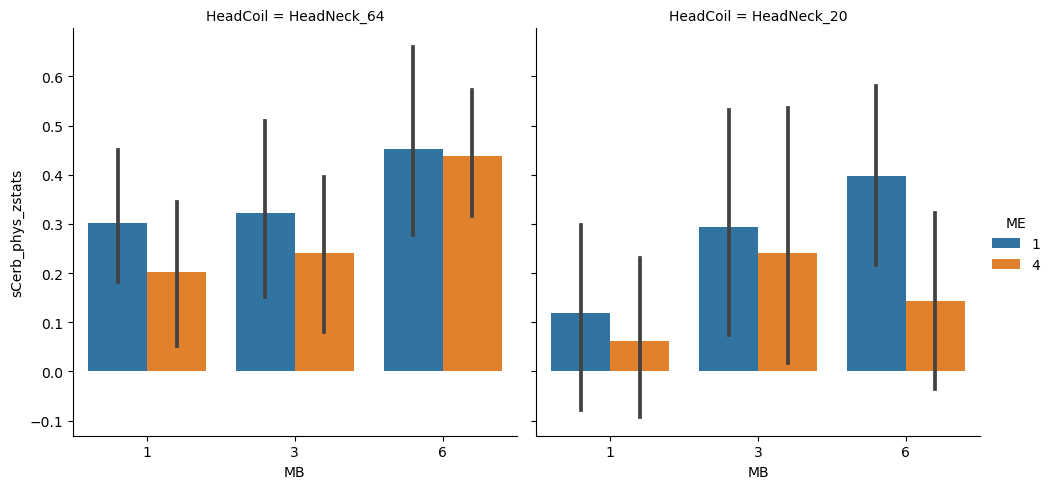

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    sCerb_phys_cope
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.1467         
Min. group size:       5          Log-Likelihood:        -102.7991      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.216    0.173  1.249 0.212 -0.123  0.554
HeadCoil[T.HeadNeck_64]        0.139    0.218  0.640 0.522 -0.288  0.566
MB                             0.020    0.044  0.448 0.654 -0.066  0.105
MB:HeadCoil[T.HeadNeck_64]    -0.055    0.055 -0.990 0.322 -0.163  0.054
ME                            -0.003    0.059 -0.046 0.963 -0.118  0.112
ME:HeadCoil[T.HeadNeck_64]    -0.023    0.074 -0.311 0.755 -0.169  0.122
MB:ME                         -0.007    0.015 -0.481 0.630 -0.037  0.022
MB:ME:HeadCoil[T.HeadNeck_64]  0.017    0.019  0.879 0.380 -0.021  0.054
Group Var                      0.000    0.024                           
========================================================================

"""

<Figure size 640x480 with 0 Axes>

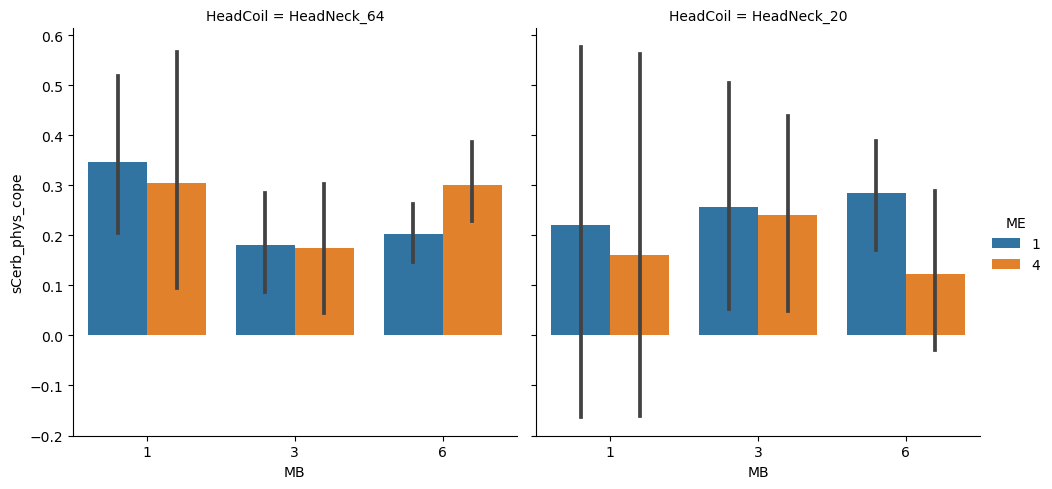

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [36]:
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('sCerb_phys_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('sCerb_phys_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('sCerb_phys_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='sCerb_phys_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/sCerb_phys-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('sCerb_phys_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='sCerb_phys_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/sCerb_phys-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/sCerb_phys-act_varcope.svg")
